In [3]:
# import the required modules
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# import local dictionaries
import sys; sys.path.append('/binder-test/')
from plotting_methods import mscatter, run_markers, run_colours
from indices import var_cv, lc

### **BOXPLOTS**

#### **Load the data and define the ensembles to include in the boxplot**

In [4]:
# load the netcdf containing boxplot data
da = xr.open_dataset("example_data/tas_12km_boxplots_20491201-20791130_annual.nc")

# this list defines the ordering of the boxplots: moving or removing items will alter the order displayed
ens_list = ["CMIP5-13", "CMIP5-EC", "EuroCORDEX", "ERA-EuroCORDEX", "UKCP18 12km", "UKCP18 60km"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# select first variable in dataset
da = da[list(da.data_vars)[0]] 

# split data into a dictionary containing UK means for each ensemble (squeeze() drops all 1d dimensions)
means = {k : da.sel(run = da.ensemble == k).squeeze().values for k in ens_list if k in da.ensemble}

#### **Create the boxplots**

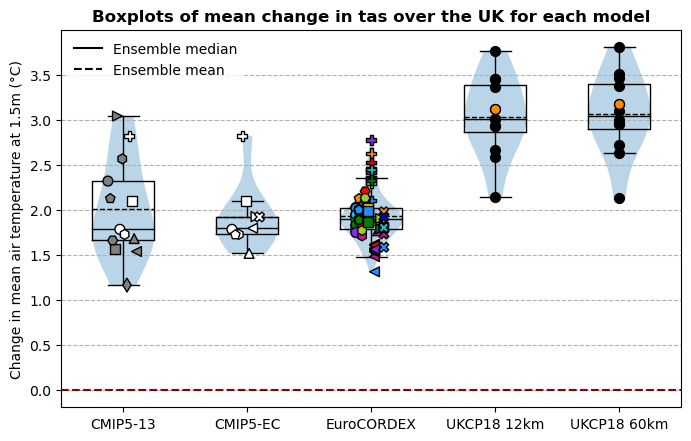

In [5]:
## CREATE THE FIGURE

fig, ax = plt.subplots(figsize = (8,5), dpi= 100, facecolor='w', edgecolor='k')
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## BOXPLOTS AND VIOLINPLOTS

# create the violinplots and boxplots from the mean values
ax.violinplot(means.values(), showextrema = False)
ax.boxplot(means.values(), labels = means.keys(), meanline = True, showmeans = True, zorder = 3, meanprops = {"color" : "black"}, medianprops = {"color" : "black"}, flierprops = {"marker" : ""})

# add a dashed line for the baseline (represents HadUK-grid observations if looking at evaluation period; set to 0 for future changes)
if "hline" in da.attrs:
    ax.axhline(da.hline, color = "darkred", ls = "--")

# add horizontal, dashed gridlines
ax.grid(axis = "y", ls = "--")


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## ADD POINTS TO REPRESENT INDIVIDUAL RUNS

# CMIP and CORDEX runs (colour denotes RCM, marker denotes GCM)
for ens_name in ["CMIP5-13", "CMIP5-EC", "EuroCORDEX", "ERA-EuroCORDEX"]:
    if ens_name in means.keys():
        
        # add jitter to each GCM to make easier to see
        runs = da.sel(run = da.ensemble == ens_name).run.str.replace("p1_.+", "p1").values
        nr = len(set(runs))
        j = 0.25 / nr     # width of offset - set to 0 to remove jitter
        jitter = {k : round(j * (x - nr/2), 5) for k, x in zip(sorted(set(runs)), range(nr))}

        # identify column & points
        i = list(means.keys()).index(ens_name) + 1
        py = means[ens_name]
        
        # draw points
        mscatter([i + jitter[r] for r in runs], py, m = run_markers(da.sel(run = da.ensemble == ens_name)), c = run_colours(da.sel(run = da.ensemble == ens_name)),
                 edgecolor = "k", s = 50, zorder = 5, ax = ax)
        
# UKCP18 runs (all same symbol, unperturbed run is highlighted)
for ens_name in ["UKCP18 12km", "UKCP18 60km"]:
    if ens_name in means.keys():
        i = list(means.keys()).index(ens_name) + 1
        px = means[ens_name]
        
        ax.scatter(np.repeat(i, len(px)), px, color = "black", marker = "o", edgecolor = "k", zorder = 5, s = 50)
        ax.scatter(i, da.sel(run = da.ensemble == ens_name).sel(run = "01"), color = "darkorange", marker = "o", edgecolor = "k", zorder = 5, s = 50)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## TITLES, AXIS LABELS, LEGEND

# add a title
if da.period in ["19890101-20081231", "19801201-20101130"]:
    ax.set_title("Boxplots of mean "+da.name+" over the UK for each model", fontweight = "bold")
else:
    ax.set_title("Boxplots of mean change in "+da.name+" over the UK for each model", fontweight = "bold")

    
# add y-axis label
if da.period in ["19890101-20081231", "19801201-20101130"]:
    ax.set_ylabel(var_cv[da.name]["plot_label"])
else:
    ax.set_ylabel("Change in "+lc(var_cv[da.name]["plot_label"]))
    
# create legend for boxplots
bplot_handles = [matplotlib.lines.Line2D([], [], color = c, linestyle = s) for c, s in zip(["black", "black", "darkred"], ["-", "--", "--"])]
bplot_labels = ["Ensemble median", "Ensemble mean", "Observed"]

# contents of legend depends on whether we're looking at the evaluation period or not
if da.period in ["19890101-20081231"]:
    ax.legend(handles = bplot_handles, labels = bplot_labels, edgecolor = "white", loc = "best")
else:
    ax.legend(handles = bplot_handles[:2], labels = bplot_labels[:2], edgecolor = "white", loc = "best")
    